In [1]:
import os
from typing import Literal

os.environ["KERAS_BACKEND"] = "torch"

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from einops import parse_shape, rearrange
from keras_core.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics as skm
from keras_core.callbacks import ModelCheckpoint, EarlyStopping
from keras_core.models import load_model

In [3]:
def generate_data(csv_path, label, ratio=0.85, scaler="minmax", train_lookback=50, test_lookback=30):
    dataset = pd.read_csv(csv_path)
    dataset.set_index("datetime", inplace=True)
    label_index = dataset.columns.values.tolist().index(label)

    train, test = train_test_split(dataset, train_size=ratio, shuffle=False)
    # train.shape, test.shape

    train = train.values
    test = test.values

    train_X = []
    train_y = []

    for i in range(train_lookback, len(train)):
        train_X.append(train[i - train_lookback : i, :])
        train_y.append(train[i, label_index])
    train_X = np.array(train_X)
    train_y = np.expand_dims(np.array(train_y), axis=-1)

    test_X = []
    test_y = []

    for i in range(test_lookback, len(test)):
        test_X.append(test[i - test_lookback : i, :])
        test_y.append(test[i, label_index])
    test_X = np.array(test_X)
    test_y = np.expand_dims(np.array(test_y), axis=-1)
    # train_X.shape,train_y.shape,test_X.shape,test_y.shape

    if scaler == "zscore":
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler == "minmax":
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()

    x_shape = parse_shape(train_X, "N L C")
    train_X = X_scaler.fit_transform(rearrange(train_X, "N L C -> (N L) C"))
    train_X = rearrange(train_X, "(N L) C -> N L C", **x_shape)

    x_shape = parse_shape(test_X, "N L C")
    test_X = X_scaler.transform(rearrange(test_X, "N L C -> (N L) C"))
    test_X = rearrange(test_X, "(N L) C -> N L C", **x_shape)

    train_y = y_scaler.fit_transform(train_y)
    test_y = y_scaler.transform(test_y)

    # train_X.shape,train_y.shape,test_X.shape,test_y.shape

    return train_X, train_y, test_X, test_y, X_scaler, y_scaler

In [4]:
import keras_core as keras
from keras_core.layers import SimpleRNN, GRU, LSTM, Bidirectional, Dropout, Dense, InputLayer, Conv1D, Permute, Flatten, Input

def RNNModel(kind: Literal["rnn", "gru", "lstm"], shape, units=64, layers=2, bi=False, dropout=0.5):
    lst = [InputLayer(shape)]
    if layers > 1:
        if isinstance(units, list):
            assert len(units) == layers
        elif isinstance(units, int):
            units = [units] * layers
        for i in range(layers - 1):
            j = units[i]
            if bi:
                if kind == "rnn":
                    lst.append(Bidirectional(SimpleRNN(j // 2, return_sequences=True)))
                elif kind == "gru":
                    lst.append(Bidirectional(GRU(j // 2, return_sequences=True)))
                elif kind == "lstm":
                    lst.append(Bidirectional(LSTM(j // 2, return_sequences=True)))
            else:
                if kind == "rnn":
                    lst.append(SimpleRNN(j, return_sequences=True))
                elif kind == "gru":
                    lst.append(GRU(j, return_sequences=True))
                elif kind == "lstm":
                    lst.append(LSTM(j, return_sequences=True))
        if bi:
            if kind == "rnn":
                lst.append(Bidirectional(SimpleRNN(units[-1] // 2)))
            elif kind == "gru":
                lst.append(Bidirectional(GRU(units[-1] // 2)))
            elif kind == "lstm":
                lst.append(Bidirectional(LSTM(units[-1] // 2)))
        else:
            if kind == "rnn":
                lst.append(SimpleRNN(units[-1]))
            elif kind == "gru":
                lst.append(GRU(units[-1]))
            elif kind == "lstm":
                lst.append(LSTM(units[-1]))
    else:
        if bi:
            if kind == "rnn":
                lst.append(Bidirectional(SimpleRNN(units // 2)))
            elif kind == "gru":
                lst.append(Bidirectional(GRU(units // 2)))
            elif kind == "lstm":
                lst.append(Bidirectional(LSTM(units // 2)))
        else:
            if kind == "rnn":
                lst.append(SimpleRNN(units))
            elif kind == "gru":
                lst.append(GRU(units))
            elif kind == "lstm":
                lst.append(LSTM(units))
    lst.append(Dropout(dropout))
    lst.append(Dense(1))
    model = keras.Sequential(lst)
    return model

In [5]:
from keras_nlp.layers import TransformerEncoder

def Transformer(
    input_shape,
    inter_dim,
    num_heads,
    num_transformer_blocks,
    trans_dropout=0.5,
    dropout=0.5,
):
    inputs = Input(shape=input_shape)
    x = inputs
    if isinstance(inter_dim, list):
        assert len(inter_dim) == num_transformer_blocks
        for _dim in inter_dim:
            x = TransformerEncoder(_dim, num_heads, dropout=trans_dropout)(x)
    else:
        for _ in range(num_transformer_blocks):
            x = TransformerEncoder(inter_dim, num_heads, dropout=trans_dropout)(x)
    x = x[:, 0, :]
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)
    return keras.Model(inputs, outputs)

2023-11-24 18:57:02.734969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 18:57:02.754821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 18:57:02.754837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 18:57:02.755553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 18:57:02.759016: I tensorflow/core/platform/cpu_feature_guar

In [6]:
@keras.saving.register_keras_serializable(package="my_package", name="root_mean_squared_error")
def root_mean_squared_error(y_true, y_pred):
    return torch.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
label = {"adjClose": "Adj_Close", "Delta": "Residual"}
ratio = 0.85
train_lookback = 50
test_lookback = 50
patience = 100
epochs = 200
batch_size = 512
repeat = 5
scaler = "minmax"
# scaler = "zscore"
csv_path = {"Basic": "data/aapl_qlib.csv", "Feat_ENG": "data/feat_eng_raw.csv", "Feat_ENG_sel": "data/feat_eng_filtered.csv"}

result = {}
for k in label.keys():
    result[k] = {}
    for k2 in csv_path.keys():
        result[k][k2] = {}
result

{'adjClose': {'Basic': {}, 'Feat_ENG': {}, 'Feat_ENG_sel': {}},
 'Delta': {'Basic': {}, 'Feat_ENG': {}, 'Feat_ENG_sel': {}}}

In [8]:
for l_name, _label in label.items():
    for d_name, _csv in csv_path.items():
        train_X, train_y, test_X, test_y, X_scaler, y_scaler = generate_data(_csv, _label, scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
        for key, model_name in {"RNN": "rnn", "LSTM": "lstm", "GRU": "gru", "Bi_GRU": "gru", "Transformer": None}.items():
            pred = []
            for _ in range(repeat):
                if key == "Transformer":
                    model = Transformer(train_X.shape[1:], [64, 32], num_heads=4, num_transformer_blocks=2, trans_dropout=0.5, dropout=0.5)
                else:
                    if key == "Bi_GRU":
                        model = RNNModel(model_name, train_X.shape[1:], units=[64, 32], layers=2, bi=True, dropout=0.5)
                    else:
                        model = RNNModel(model_name, train_X.shape[1:], units=[64, 32], layers=2, bi=False, dropout=0.5)
                model.compile(loss=root_mean_squared_error, optimizer="adam")
                # model.summary()
                checkpoint = ModelCheckpoint("model.weights.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min")
                early_stopping = EarlyStopping(monitor="val_loss", patience=patience, verbose=1, mode="min", restore_best_weights=True)
                model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping])
                model.load_weights("model.weights.h5")
                pred.append(model.predict(test_X))
                del model
            result[l_name][d_name][key] = np.array(pred).mean(0).reshape(-1, 1)

/home/ziyang/miniconda3/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5552
Epoch 1: val_loss improved from inf to 1.75411, saving model to model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5478 - val_loss: 1.7541
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3107
Epoch 2: val_loss improved from 1.75411 to 1.51012, saving model to model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3075 - val_loss: 1.5101
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1952
Epoch 3: val_loss improved from 1.51012 to 1.37671, saving model to model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1940 - val_loss: 1.3767
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1414
Epoch 4: val_loss improved from 1.37671 to 1.34488, saving model to model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1407 - val_loss: 1.3449
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1111
Epoch 5: val_loss improved from 1

In [9]:
result_df = pd.DataFrame.from_dict({(i, j): result[i][j] for i in result.keys() for j in result[i].keys()}, orient="index")

In [1]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Adj_Close", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
close_df = result_df.loc["adjClose"]
gt = test_y
sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Value")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()

NameError: name 'generate_data' is not defined

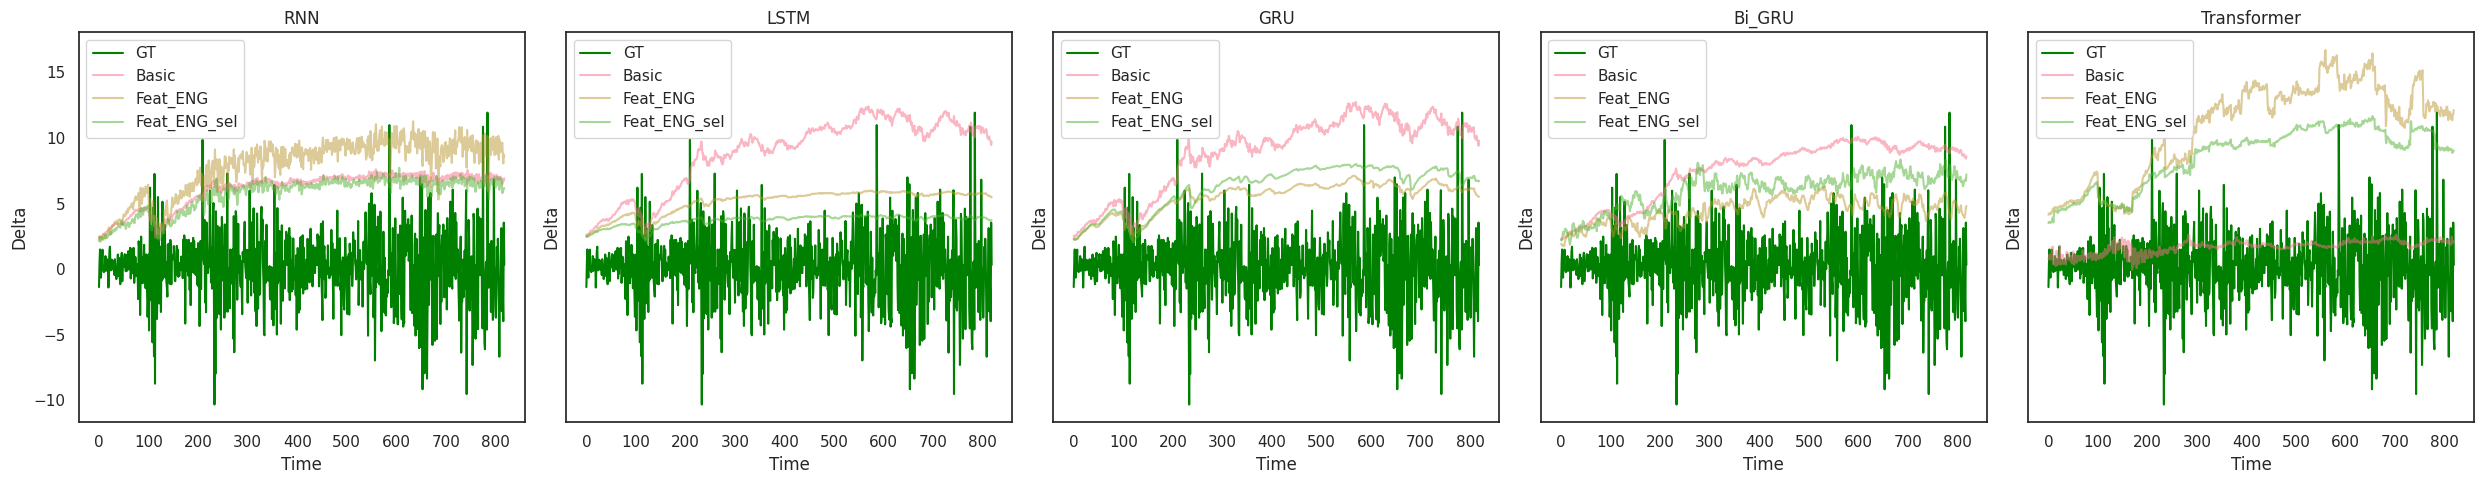

In [11]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Residual", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
Delta_df = result_df.loc["Delta"]
gt = test_y

sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Delta")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
"\\begin{tabular}{lrrrrrrrrrrrrrrrrrr}\n\\toprule\n & \\multicolumn{6}{r}{Basic} & \\multicolumn{6}{r}{Feat_ENG} & \\multicolumn{6}{r}{Feat_ENG_sel} \\\\\n & MSE & RMSE & MAE & MAPE & RMSLE & R2 & MSE & RMSE & MAE & MAPE & RMSLE & R2 & MSE & RMSE & MAE & MAPE & RMSLE & R2 \\\\\n\\midrule\nRNN & 0.674051 & 0.821006 & 0.699438 & 0.276611 & 0.260261 & -0.753668 & 0.300882 & 0.548528 & 0.443378 & 0.173743 & 0.163924 & 0.217198 & 0.764640 & 0.874437 & 0.758133 & 0.304674 & 0.281622 & -0.989353 \\\\\nLSTM & 0.117622 & 0.342961 & 0.277231 & 0.107264 & 0.097279 & 0.693985 & 0.955228 & 0.977358 & 0.847041 & 0.338283 & 0.322096 & -1.485203 & 1.460750 & 1.208615 & 1.068284 & 0.433095 & 0.422641 & -2.800413 \\\\\nGRU & 0.104699 & 0.323572 & 0.263634 & 0.102782 & 0.091583 & 0.727606 & 0.822888 & 0.907132 & 0.791333 & 0.318368 & 0.294595 & -1.140897 & 0.602826 & 0.776419 & 0.677360 & 0.273932 & 0.245265 & -0.568365 \\\\\nBi_GRU & 0.311547 & 0.558164 & 0.481533 & 0.194274 & 0.167734 & 0.189453 & 1.149805 & 1.072290 & 0.947952 & 0.386102 & 0.363772 & -1.991432 & 0.718651 & 0.847733 & 0.732635 & 0.296639 & 0.271875 & -0.869703 \\\\\nTransformer & 2.237649 & 1.495877 & 1.381931 & 0.587531 & 0.568777 & -4.821659 & 0.052489 & 0.229105 & 0.178628 & 0.087904 & 0.071292 & 0.863440 & 0.191321 & 0.437402 & 0.364606 & 0.152211 & 0.129119 & 0.502243 \\\\\n\\bottomrule\n\\end{tabular}\n"

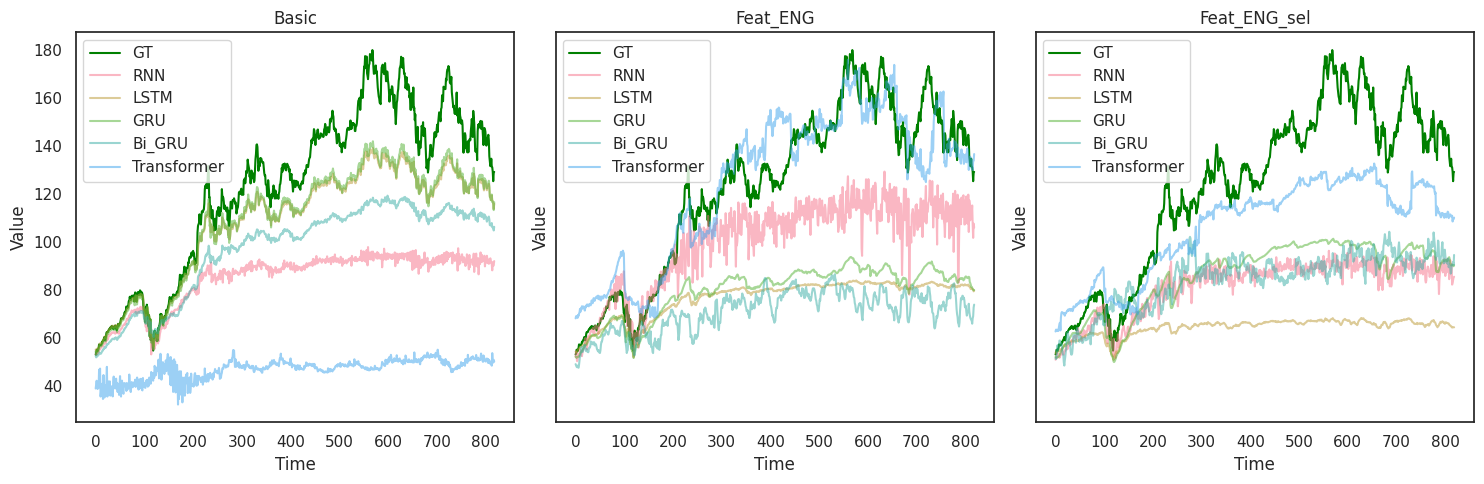

In [12]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Adj_Close", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
close_df = result_df.loc["adjClose"].T
gt = test_y
sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Value")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()

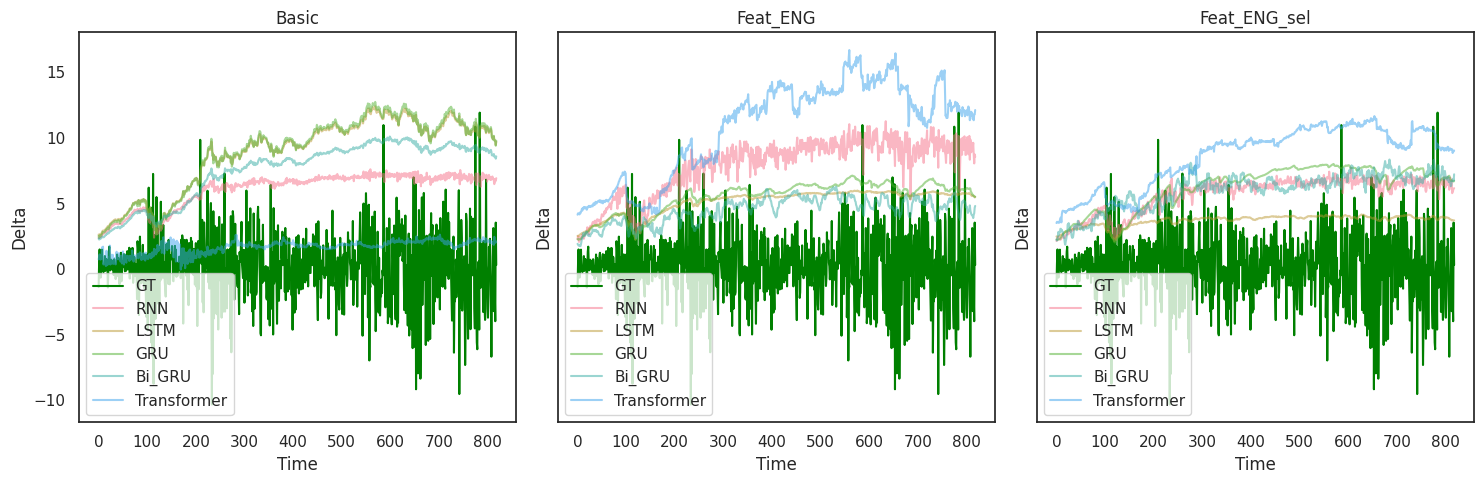

In [13]:
_, _, _, test_y, _, y_scaler = generate_data(list(csv_path.values())[0], "Residual", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
Delta_df = result_df.loc["Delta"].T
gt = test_y
sns.set(style="white")
sns.set_palette("husl")

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for idx, (columnName, columnData) in enumerate(close_df.items()):
    ax[idx].plot(y_scaler.inverse_transform(gt), label="GT", color="green")
    for _, (name, value) in enumerate(columnData.items()):
        ax[idx].plot(y_scaler.inverse_transform(value), label=name, alpha=0.5)
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Delta")
    ax[idx].set_title(columnName)
    ax[idx].legend()

plt.tight_layout()
plt.show()

In [69]:
_, _, _, dlt_test_y, _, _ = generate_data(list(csv_path.values())[0], "Residual", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)
_, _, _, adj_test_y, _, _ = generate_data(list(csv_path.values())[0], "Adj_Close", scaler=scaler, train_lookback=train_lookback, test_lookback=test_lookback)

adj_df = result_df.loc["adjClose"]
dlt_df = result_df.loc["Delta"]

In [91]:
adj_met_df = pd.DataFrame(
    np.random.random(size=(5, 18)),
    index=adj_df.T.index.tolist(),
    columns=[
        [
            "Basic",
            "Basic",
            "Basic",
            "Basic",
            "Basic",
            "Basic",
            "Feat_ENG",
            "Feat_ENG",
            "Feat_ENG",
            "Feat_ENG",
            "Feat_ENG",
            "Feat_ENG",
            "Feat_ENG_sel",
            "Feat_ENG_sel",
            "Feat_ENG_sel",
            "Feat_ENG_sel",
            "Feat_ENG_sel",
            "Feat_ENG_sel",
        ],
        ["MSE", "RMSE", "MAE", "MAPE", "RMSLE", "R2", "MSE", "RMSE", "MAE", "MAPE", "RMSLE", "R2", "MSE", "RMSE", "MAE", "MAPE", "RMSLE", "R2"],
    ],
)

for i in ["RNN", "LSTM", "GRU", "Bi_GRU", "Transformer"]:
    for j in ["Basic", "Feat_ENG", "Feat_ENG_sel"]:
        y_pred = adj_df.T.loc[i][j]
        for k in ["MSE", "RMSE", "MAE", "MAPE", "RMSLE", "R2"]:
            if k == "MSE":
                tmp_value = skm.mean_squared_error(adj_test_y, y_pred)
            elif k == "RMSE":
                tmp_value = skm.mean_squared_error(adj_test_y, y_pred, squared=False)
            elif k == "MAE":
                tmp_value = skm.mean_absolute_error(adj_test_y, y_pred)
            elif k == "MAPE":
                tmp_value = skm.mean_absolute_percentage_error(adj_test_y, y_pred)
            elif k == "RMSLE":
                tmp_value = skm.mean_squared_log_error(adj_test_y, y_pred, squared=False)
            elif k == "R2":
                tmp_value = skm.r2_score(adj_test_y, y_pred)
            adj_met_df.loc[i, (j, k)] = tmp_value

adj_met_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrr}\n\\toprule\n & \\multicolumn{6}{r}{Basic} & \\multicolumn{6}{r}{Feat_ENG} & \\multicolumn{6}{r}{Feat_ENG_sel} \\\\\n & MSE & RMSE & MAE & MAPE & RMSLE & R2 & MSE & RMSE & MAE & MAPE & RMSLE & R2 & MSE & RMSE & MAE & MAPE & RMSLE & R2 \\\\\n\\midrule\nRNN & 0.674051 & 0.821006 & 0.699438 & 0.276611 & 0.260261 & -0.753668 & 0.300882 & 0.548528 & 0.443378 & 0.173743 & 0.163924 & 0.217198 & 0.764640 & 0.874437 & 0.758133 & 0.304674 & 0.281622 & -0.989353 \\\\\nLSTM & 0.117622 & 0.342961 & 0.277231 & 0.107264 & 0.097279 & 0.693985 & 0.955228 & 0.977358 & 0.847041 & 0.338283 & 0.322096 & -1.485203 & 1.460750 & 1.208615 & 1.068284 & 0.433095 & 0.422641 & -2.800413 \\\\\nGRU & 0.104699 & 0.323572 & 0.263634 & 0.102782 & 0.091583 & 0.727606 & 0.822888 & 0.907132 & 0.791333 & 0.318368 & 0.294595 & -1.140897 & 0.602826 & 0.776419 & 0.677360 & 0.273932 & 0.245265 & -0.568365 \\\\\nBi_GRU & 0.311547 & 0.558164 & 0.481533 & 0.194274 & 0.167734 & 0.189453 & 1.14

In [90]:
dlt_met_df = pd.DataFrame(
    np.random.random(size=(5, 12)),
    index=adj_df.T.index.tolist(),
    columns=[
        ["Basic", "Basic", "Basic", "Basic", "Feat_ENG", "Feat_ENG", "Feat_ENG", "Feat_ENG", "Feat_ENG_sel", "Feat_ENG_sel", "Feat_ENG_sel", "Feat_ENG_sel"],
        ["RMSE", "MAE", "MAPE", "R2", "RMSE", "MAE", "MAPE", "R2", "RMSE", "MAE", "MAPE", "R2"],
    ],
)

for i in ["RNN", "LSTM", "GRU", "Bi_GRU", "Transformer"]:
    for j in ["Basic", "Feat_ENG", "Feat_ENG_sel"]:
        y_pred = dlt_df.T.loc[i][j]
        for k in ["RMSE", "MAE", "MAPE", "R2"]:
            if k == "RMSE":
                tmp_value = skm.mean_squared_error(dlt_test_y, y_pred, squared=False)
            elif k == "MAE":
                tmp_value = skm.mean_absolute_error(dlt_test_y, y_pred)
            elif k == "MAPE":
                tmp_value = skm.mean_absolute_percentage_error(dlt_test_y, y_pred)
            elif k == "R2":
                tmp_value = skm.r2_score(dlt_test_y, y_pred)
            dlt_met_df.loc[i, (j, k)] = tmp_value

dlt_met_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n & \\multicolumn{4}{r}{Basic} & \\multicolumn{4}{r}{Feat_ENG} & \\multicolumn{4}{r}{Feat_ENG_sel} \\\\\n & RMSE & MAE & MAPE & R2 & RMSE & MAE & MAPE & R2 & RMSE & MAE & MAPE & R2 \\\\\n\\midrule\nRNN & 0.421675 & 0.308876 & 2.952300 & -0.049981 & 0.415914 & 0.303362 & 2.944294 & -0.021487 & 0.413941 & 0.301335 & 2.864959 & -0.011822 \\\\\nLSTM & 0.411593 & 0.299586 & 2.966548 & -0.000375 & 0.411841 & 0.299789 & 2.953207 & -0.001581 & 0.411467 & 0.299684 & 2.967061 & 0.000238 \\\\\nGRU & 0.411263 & 0.299473 & 2.883696 & 0.001229 & 0.411548 & 0.299576 & 2.975835 & -0.000156 & 0.411030 & 0.299449 & 2.931028 & 0.002362 \\\\\nBi_GRU & 0.410778 & 0.298923 & 2.945979 & 0.003581 & 0.410707 & 0.297927 & 2.921406 & 0.003928 & 0.411549 & 0.299270 & 2.905665 & -0.000162 \\\\\nTransformer & 0.411500 & 0.299585 & 3.005914 & 0.000077 & 0.411504 & 0.299607 & 3.019823 & 0.000057 & 0.411532 & 0.299646 & 3.009598 & -0.000078 \\\\\n\\bottomrule\n\\end{tabular}